<a href="https://colab.research.google.com/github/philqc/Deep-Value-Networks-Pytorch/blob/master/FCN_baseline_Img_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import numbers
import random
import os
import pickle
import time
import math
import copy
import pdb
from skimage import io

For some reason, we are getting AttributeError: module 'PIL.Image' has no attribute 'register_extensions if we don't install pillow version 4.1.1

In [2]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# directory path to store results/plots/models
dir_path = 'drive/My Drive/projet_asp'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Auxiliary functions

In [0]:
class MyDataset(Dataset):

    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

    def __len__(self):
        return len(self.inputs)


def show_img(img, black_and_white=True):
    np_img = img.numpy()
    # put channel at the end for plt.imshow
    if np_img.ndim == 3:
        np_img = np.transpose(np_img, (1, 2, 0))

    #print('np_img.shape', np_img.shape)
    if black_and_white:
        plt.imshow(np_img, cmap='Greys_r')
        plt.show()
    else:
        plt.imshow(np_img)
        plt.show()


def save_img(img, path_to_save, black_and_white=True):
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    if black_and_white:
        plt.imsave(path_to_save + ".jpg", np_img, cmap='Greys_r')
    else:
        plt.imsave(path_to_save + ".jpg", np_img)


def save_grid_imgs(input_imgs, path_to_save, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)
    save_img(img, path_to_save, black_and_white)
    
def show_grid_imgs(input_imgs, black_and_white=True):
    img = utils.make_grid(input_imgs, nrow=8)  
    show_img(img, black_and_white)


def plot_results(results, iou):
    """
    Parameters:
    ----------
    results: dictionary with the train/valid loss
    and the f1 scores]
    iou: bool
      if true: print IOU, else print F1 Score
    """
    str_score = 'IOU' if iou else 'F1 Score'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title('Validation Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax2.set_title('Validation ' + str_score)
    ax2.set_ylabel(str_score)
    ax2.set_xlabel('epochs')

    ax1.plot(results['loss_train'], label='loss_train')
    ax1.plot(results['loss_valid'], label='loss_valid')
    if iou:
      ax2.plot(results['IOU_valid'])
    else:
      ax2.plot(results['f1_valid'])
      
    ax1.legend()
    plt.show()

Deep Value Network

In [0]:
def cross_entropy2d(inputs, target, weight=None, size_average=False):
    """https://github.com/RohanDoshi2018/pytorch-fcn/blob/master/torchfcn/trainer.py"""
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = inputs.size()
    target = target.view(n, h, w)
    #print('n ={}; c = {}; h = {}; w ={}'.format(n, c, h, w))
    #print('inputs.size() =', inputs.size(), 'target.size() =', target.size())
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(inputs, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.permute(0, 2, 3, 1).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target.long(), weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

def thirtysix_crop(img, size):
    """ Crop the given PIL Image 32x32 into 36 crops of 24x24
    Inspired from five_crop implementation in pytorch
    https://pytorch.org/docs/master/_modules/torchvision/transforms/functional.html
    """
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
        
    w, h = img.size
    crop_h, crop_w = size
    if crop_w > w or crop_h > h:
        raise ValueError("Requested crop size {} is bigger than input size {}"
                         "".format(size, (h, w)))
    crops = []    
    for i in [0, 2, 3, 4, 5, 8]:
        for j in [0, 2, 3, 4, 5, 8]:
            c = img.crop((i, j, crop_w + i, crop_h + j))
            if c.size != size:
                raise ValueError("Crop size is {} but should be {}"
                                 "".format( c.size, size))
            crops.append(c)
               
    return crops
    
    
def average_over_crops(crops, device):
    N, n_crops, n_class, h, w = crops.shape
    pred = crops.permute(0, 1, 3, 4, 2).contiguous().view(-1, n_class).argmax(dim=1).view(N, n_crops, h, w)
        
    final = torch.zeros(N, 32, 32).to(device)
    size = torch.zeros(32, 32).to(device)
    for i, x in enumerate([0, 2, 3, 4, 5, 8]):
        for j, y in enumerate([0, 2, 3, 4, 5, 8]):
            k = i * 6 + j
            #pdb.set_trace()
            final[:, x: w + x, y:h + y] += pred[:, k].float()
            size[x: w + x, y:h + y] += 1
    
    final /= size
    final = final.view(N, 1, 32, 32)
    #pdb.set_trace()
    return final 

  
class FCNBaseLine(nn.Module):

    def __init__(self, non_linearity='relu', use_batch_norm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 5, 2, padding=2)
        self.conv3 = nn.Conv2d(128, 128, 5, 2, padding=2)

        # Taken from https://openreview.net/forum?id=By40DoAqtX
        #self.deconv1 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)
        #self.deconv2 = nn.ConvTranspose2d(1, 1, kernel_size=8, stride=4, padding=14)

        # Mine
        self.deconv1 = nn.ConvTranspose2d(128, 2, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(2, 2, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else None
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else None
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else None
        self.bn4 = nn.BatchNorm2d(2) if use_batch_norm else None

        non_linearity = non_linearity.lower()
        if non_linearity == 'softplus':
            self.non_linearity = nn.Softplus()
        elif non_linearity == 'relu':
            self.non_linearity = nn.ReLU()
        elif non_linearity == 'elu':
            self.non_linearity = nn.ELU()
        elif non_linearity == 'tanh':
            self.non_linearity = nn.Tanh()
        else:
            raise ValueError('Unknown activation Convnet:', non_linearity)
         
        self.use_batch_norm = use_batch_norm
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, z):
        #print('(0) z.shape=', z.shape)
        if self.use_batch_norm:
            z = self.non_linearity(self.bn1(self.conv1(z)))
            #print('(1) z.shape=', z.shape)
            z = self.non_linearity(self.bn2(self.conv2(z)))
            #print('(2) z.shape=', z.shape)
            z = self.non_linearity(self.bn3(self.conv3(z)))
            #print('(3) z.shape=', z.shape)
            z = self.non_linearity(self.bn4(self.deconv1(z)))
            #print('(4) z.shape=', z.shape)
            z = self.deconv2(z)
        else:
            z = self.non_linearity(self.conv1(z))
            z = self.non_linearity(self.conv2(z))
            z = self.non_linearity(self.conv3(z))
            z = self.non_linearity(self.deconv1(z))
            #z = self.dropout(z)
            z = self.deconv2(z)

        #print('(5) z.shape=', z.shape)
        return z  # size = (N, n_class, x.H/1, x.W/1)

      

class FullyConvNet:
    def __init__(self, train_loader, valid_loader, dir_path, use_cuda,
                 non_linearity='relu', learning_rate=1e-3, feature_dim=(24, 24), label_dim=(24, 24)):

        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.feature_dim = feature_dim
        self.label_dim = label_dim

        # Using standard FCN
        self.model = FCNBaseLine(non_linearity, use_batch_norm=True).to(self.device)

        # Binary Cross entropy loss
        # Computes independent loss for each label in the vector
        # Our final loss is the sum over all our losses
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

        # Hyperparameters from LDRSP paper
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, 
                                          weight_decay=1e-4)

        self.n_class = 2       
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.n_train = len(train_loader.dataset)
        self.n_valid = len(valid_loader.dataset)
        print('Using a {} train {} validation split'.format(self.n_train, self.n_valid))
        self.batch_size = train_loader.batch_size
        self.batch_size_eval = valid_loader.batch_size
        
        # turn on/off
        self.training = False

    def get_oracle_value(self, pred_labels, gt_labels):
        """
        Compute the ground truth value, i.e. v*(y, y*)
        of some predicted labels, where v*(y, y*)
        is the relaxed version of the IOU (intersection
        over union) when training, and the discrete IOU
        when validating/testing
        """
        if pred_labels.shape != gt_labels.shape:
            raise ValueError('Invalid labels shape: gt = ', gt_labels.shape, 'pred = ', pred_labels.shape)

        if not self.training:
            # No relaxation, 0-1 only
            pred_labels = torch.where(pred_labels >= 0.5,
                                      torch.ones(1).to(self.device),
                                      torch.zeros(1).to(self.device))
            pred_labels = pred_labels.float()

        pred_labels = torch.flatten(pred_labels).reshape(pred_labels.size()[0], -1)
        gt_labels = torch.flatten(gt_labels).reshape(gt_labels.size()[0], -1)

        intersect = torch.min(pred_labels, gt_labels)
        union = torch.max(pred_labels, gt_labels)

        # for numerical stability
        epsilon = torch.full(union.size(), 10 ** -8).to(self.device)

        f1 = 2 * intersect / (intersect + torch.max(epsilon, union))
        # we want a (Batch_size x 1) tensor
        #iou = iou.view(-1, 1)
        #pdb.set_trace()
        return f1
      
    def get_iou_value(self, pred_labels, gt_labels):
        """
        Compute the ground truth value, i.e. v*(y, y*)
        of some predicted labels, where v*(y, y*)
        is the relaxed version of the IOU (intersection
        over union) when training, and the discrete IOU
        when validating/testing
        """
        if pred_labels.shape != gt_labels.shape:
            raise ValueError('Invalid labels shape: gt = ', gt_labels.shape, 'pred = ', pred_labels.shape)

        if not self.training:
            # No relaxation, 0-1 only
            pred_labels = torch.where(pred_labels >= 0.5,
                                      torch.ones(1).to(self.device),
                                      torch.zeros(1).to(self.device))
            pred_labels = pred_labels.float()

        pred_labels = torch.flatten(pred_labels).reshape(pred_labels.size()[0], -1)
        gt_labels = torch.flatten(gt_labels).reshape(gt_labels.size()[0], -1)

        intersect = torch.sum(torch.min(pred_labels, gt_labels), dim=1)
        union = torch.sum(torch.max(pred_labels, gt_labels), dim=1)

        # for numerical stability
        epsilon = torch.full(union.size(), 10 ** -8).to(self.device)
        
        iou = intersect / torch.max(epsilon, union)
        # we want a (Batch_size x 1) tensor
        iou = iou.view(-1, 1)
        #pdb.set_trace()
        return iou

    def train(self, ep):

        self.model.train()
        self.training = True

        time_start = time.time()
        t_loss, t_size = 0, 0
        
        for batch_idx, (raw_inputs, inputs, targets) in enumerate(self.train_loader):

            inputs, targets = inputs.to(self.device), targets.to(self.device)
            inputs, targets = inputs.float(), targets.float()
            
            t_size += len(inputs)

            self.model.zero_grad()

            output = self.model(inputs)
            
            loss = cross_entropy2d(output, targets)           
            t_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            
            # Get prediction accross (argmax accross n_class depth)
            N, c, h, w = output.shape
            pred = output.permute(0, 2, 3, 1).contiguous().view(-1, c).argmax(dim=1).view(N, 1, h, w)
                        
            if batch_idx % 2 == 0:
                print('\rTraining Epoch {} [{} / {} ({:.0f}%)]: Time per epoch: {:.2f}s; '
                      'Avg_Loss = {:.5f}; IOU_batch = {:.2f}%'
                      ''.format(ep, t_size, self.n_train, 100 * t_size / self.n_train,
                               (self.n_train / t_size) * (time.time() - time_start), t_loss / t_size,
                               100 * self.get_iou_value(pred.float(), targets).mean()),
                      end='')
        
        if ep % 50 == 0:
            print('\nTRAIN ')
            img = raw_inputs.detach().cpu()
            show_grid_imgs(img)
               
            mask = pred.detach().cpu()
            # Put mask to float otherwise only outputs black images !!
            show_grid_imgs(mask.float())   
            print('---------------------------------------')
            
        t_loss /= t_size
        self.training = False
        print('')
        return t_loss

    def valid(self, loader, test_set=False, ep=0):

        self.model.eval()
        self.training = False

        loss, t_size = 0, 0
        mean_iou = []
        
        with torch.no_grad():
            for (raw_inputs, inputs, targets) in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                inputs, targets = inputs.float(), targets.float()
            
                t_size += len(inputs)
                
                # For valid/test: inputs is a 5d tensor
                bs, ncrops, channels, h, w = inputs.size()
                
                output = self.model(inputs.view(-1, channels, h, w)) # fuse batch size and ncrops
                # go back to normal shape
                output = output.view(bs, ncrops, self.n_class, h, w)
                
                pred = average_over_crops(output, self.device)
                #output_avg = output.view(bs, ncrops, -1).mean(1) # avg over crops
                
                # go back to normal shape
                #output_avg = output_avg.view(bs, -1, h, w)
                
                #loss += cross_entropy2d(output_avg, targets)
                
                # Get prediction accross (argmax accross n_class depth)
                #N, n_class, h, w = output_avg.shape
                #pred = output_avg.permute(0, 2, 3, 1).contiguous().view(-1, n_class).argmax(dim=1).view(N, 1, h, w)
                
                mean_iou.append(self.get_iou_value(pred.float(), targets).mean()) 
                
        if ep % 50 == 0:
            img = raw_inputs.detach().cpu()
            show_grid_imgs(img) 
            mask = pred.detach().cpu()
            mask = mask >= 0.5
            # Put mask to float otherwise only outputs black images !!
            show_grid_imgs(mask.float())        
        
        mean_iou = torch.stack(mean_iou)
        mean_iou = torch.mean(mean_iou)
        mean_iou = mean_iou.cpu().numpy()
        loss /= t_size

        str_first = 'Test set' if test_set else 'Validation set'
        print('{}: IOU = {:.2f}%'
              ''.format(str_first, 100 * mean_iou))

        return loss, mean_iou


Functions to run epoch and also to run hyperparameter search

In [0]:
def run_fcn_model(train_loader, valid_loader, dir_path, use_cuda, n_epochs):

    FCN = FullyConvNet(train_loader, valid_loader, dir_path, use_cuda)

    results = {'name': 'FCN_Whorse', 'loss_train': [],
               'loss_valid': [], 'IOU_valid': [], 'batch_size': train_loader.batch_size,
               'batch_size_eval': valid_loader.batch_size}

    results_path = dir_path + '/results/'
    if not os.path.isdir(results_path):
        os.makedirs(results_path)

    # Increment a counter so that previous results with the same args will not
    # be overwritten. Comment out the next four lines if you only want to keep
    # the most recent results.
    i = 0
    while os.path.exists(results_path + str(i) + '.pkl'):
        i += 1
    results_path = results_path + str(i)

    for epoch in range(n_epochs):
        loss_train = FCN.train(epoch)
        loss_valid, iou_valid = FCN.valid(FCN.valid_loader, ep=epoch)
        results['loss_train'].append(loss_train)
        results['loss_valid'].append(loss_valid)
        results['IOU_valid'].append(iou_valid)

        with open(results_path + '.pkl', 'wb') as fout:
            pickle.dump(results, fout)
        
    plot_results(results, iou=True)

Load dataset and choose to use cpu or gpu

In [15]:
# build the dataset, generate the "training tuple"
class WeizmannHorseDataset(Dataset):
    """ Weizmann Horse Dataset """
    
    def __init__(self, img_dir, mask_dir, subset='train', transform=None,
                 random_mirroring=True):
        """
        Args:
            img_dir(string): Path to the image file (training image)
            mask_dir(string): Path to the mask file (segmentation result)
            subset(string): 'train' or 'valid' or 'test'
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        all_img_names = os.listdir(img_dir)
        all_mask_names = os.listdir(mask_dir)

        self.img_names = []
        self.mask_names = []
        for i, name in enumerate(all_img_names):
            img_number = ''.join([n for n in name if n.isdigit()])
            if int(img_number) >= 200:
                if subset == 'test':
                    self.img_names.append(name)
            elif 180 <= int(img_number) < 200:
                if subset == 'valid':
                    self.img_names.append(name)
            elif subset == 'train' and int(img_number) < 180:
                self.img_names.append(name)
        
        for i, name in enumerate(all_mask_names):
            mask_number = ''.join([n for n in name if n.isdigit()]) 
            if int(mask_number) >= 200:
               if subset == 'test':
                    self.mask_names.append(name)
            elif 180 <= int(mask_number) < 200:
                if subset == 'valid':
                    self.mask_names.append(name)
            elif subset == 'train' and int(mask_number) < 180:
                self.mask_names.append(name)
        
        self.img_names.sort()
        self.mask_names.sort()
        
        assert len(self.mask_names) == len(self.img_names)
        
        self.is_test = True if subset == 'valid' or subset == 'test' else False
        
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(size=(32, 32))])
        self.random_mirroring = random_mirroring
        self.normalize = None
        self.to_tensor = transforms.ToTensor()
        
        self.transform_test = transforms.Compose([transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                                  transforms.Lambda(lambda crops: torch.stack([self.normalize(crop) for crop in crops]))])
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])
        
        image = io.imread(img_name)
        mask = io.imread(mask_name)
               
        if self.transform:
                      
            image = self.transform(image)
            
            # create a channel for mask so as to transform
            mask = self.transform(np.expand_dims(mask, axis=2))
            
            if self.is_test:
                input_img = image
                # Use 36 crops averaging for valid/test
                image = thirtysix_crop(image, 24)
                image = self.transform_test(image)
            else:
                # Random crop
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(24, 24))
                image = TF.crop(image, i, j, h, w)                
                mask = TF.crop(mask, i, j, h, w)
                
                # Random Horizontal flipping
                if self.random_mirroring and random.random() > 0.50:
                    image = TF.hflip(image)
                    mask = TF.hflip(mask)
                
                input_img = image
                image = self.to_tensor(image)
                image = self.normalize(image)
            
            input_img = self.to_tensor(input_img)      
            mask = self.to_tensor(mask)
            
            # put mask to 0-1 again
            mask = mask >= 0.5
        
        return input_img, image, mask

    def compute_mean_and_stddev(self):
        n_images = len(self.img_names)
        masks, images = [], []

        # ToTensor transforms the images/masks in range [0, 1]
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(size=(32, 32)),
                                        transforms.ToTensor()])

        for i in range(n_images):
            mask_name = os.path.join(self.mask_dir, self.mask_names[i])
            img_name = os.path.join(self.img_dir, self.img_names[i])
            mask = io.imread(mask_name)
            image = io.imread(img_name)

            image = transform(image)
            # create a channel for mask so as to transform
            mask = transform(np.expand_dims(mask, axis=2))
            
            #show_img(image, black_and_white=False)
            #show_img(mask.view(32, 32), black_and_white=True)
            masks.append(mask)
            images.append(image)

        # after torch.stack, we should have n_images x 1 x 32 x 32 for mask
        # and have n_images x 3 x 32 x 32 for images
        images, masks = torch.stack(images), torch.stack(masks)

        # compute mean and std_dev of images
        # put the images in n_images x 3 x (32x32) shape
        images = images.view(images.size(0), images.size(1), -1)
        mean_imgs = images.mean(2).sum(0) / n_images
        std_imgs = images.std(2).sum(0) / n_images
        ############################################

        # Find mean_mask for visualization purposes
        height, width = masks.shape[2], masks.shape[3]
        # flatten
        masks = masks.view(n_images, 1, -1)
        mean_mask = torch.mean(masks, dim=0)
        # go back to 32 x 32 view
        mean_mask = mean_mask.view(1, 1, height, width)

        print_mask = False
        if print_mask:
            img_to_show = mean_mask.squeeze(0)
            img_to_show = img_to_show.squeeze(0)
            show_img(img_to_show, black_and_white=True)

        return mean_imgs, std_imgs, mean_mask

# Use GPU if it is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
    
image_dir = dir_path + '/images'
mask_dir = dir_path + '/masks'

# Use Dataset to resize and convert to Tensor
train_set = WeizmannHorseDataset(image_dir, mask_dir, subset='train',
                                 transform=None, random_mirroring=True)

valid_set = WeizmannHorseDataset(image_dir, mask_dir, subset='valid',
                                 transform=None, random_mirroring=True)

batch_size = 20
batch_size_eval = 10

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size_eval,
    pin_memory=use_cuda
)

mean_imgs, std_imgs, mean_mask = train_set.compute_mean_and_stddev()
print('mean_imgs =', mean_imgs, 'std_dev_imgs =', std_imgs)

train_set.normalize = transforms.Normalize(mean_imgs, std_imgs)
valid_set.normalize = transforms.Normalize(mean_imgs, std_imgs)

mean_imgs = tensor([0.5090, 0.4993, 0.4289]) std_dev_imgs = tensor([0.2103, 0.2133, 0.2112])


In [0]:
Run the model

Using a 180 train 20 validation split
Training Epoch 0 [20 / 180 (11%)]: Time per epoch: 1.15s; Avg_Loss = 407.78408; IOU_batch = 24.17%

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


Training Epoch 0 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 400.19111; IOU_batch = 23.56%
TRAIN 


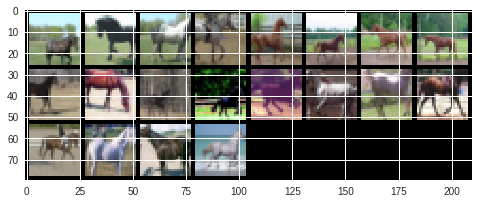

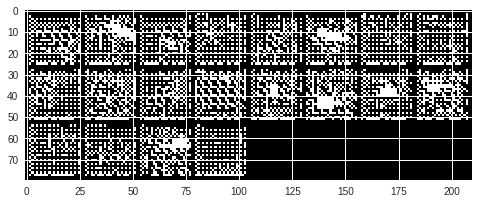

---------------------------------------



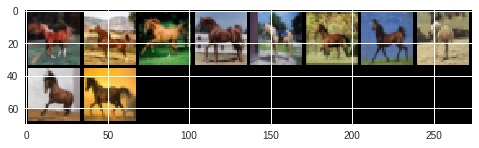

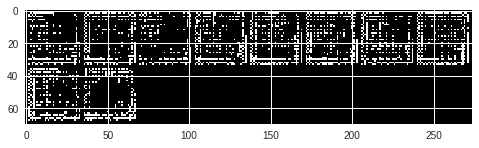

Validation set: IOU = 8.13%
Training Epoch 1 [180 / 180 (100%)]: Time per epoch: 1.08s; Avg_Loss = 391.34136; IOU_batch = 12.53%
Validation set: IOU = 0.80%
Training Epoch 2 [180 / 180 (100%)]: Time per epoch: 1.07s; Avg_Loss = 381.22949; IOU_batch = 5.98%
Validation set: IOU = 0.52%
Training Epoch 3 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 370.63264; IOU_batch = 2.95%
Validation set: IOU = 0.20%
Training Epoch 4 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 361.31898; IOU_batch = 2.40%
Validation set: IOU = 0.18%
Training Epoch 5 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 348.62924; IOU_batch = 1.02%
Validation set: IOU = 0.10%
Training Epoch 6 [180 / 180 (100%)]: Time per epoch: 1.12s; Avg_Loss = 339.68420; IOU_batch = 0.26%
Validation set: IOU = 0.05%
Training Epoch 7 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 329.88777; IOU_batch = 0.07%
Validation set: IOU = 0.01%
Training Epoch 8 [180 / 180 (100%)]: Time per epoch: 1.09s; Avg_Loss = 322.

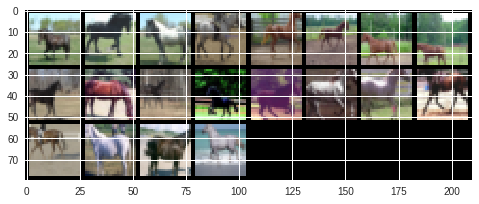

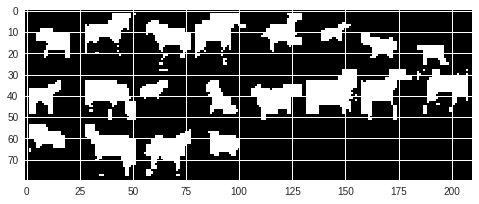

---------------------------------------



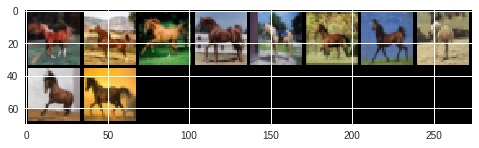

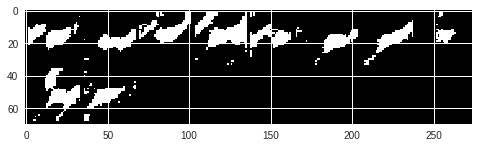

Validation set: IOU = 45.34%
Training Epoch 51 [180 / 180 (100%)]: Time per epoch: 1.11s; Avg_Loss = 181.18469; IOU_batch = 72.39%
Validation set: IOU = 50.03%
Training Epoch 52 [180 / 180 (100%)]: Time per epoch: 1.10s; Avg_Loss = 180.06884; IOU_batch = 73.12%
Validation set: IOU = 45.63%
Training Epoch 53 [180 / 180 (100%)]: Time per epoch: 1.08s; Avg_Loss = 179.42776; IOU_batch = 72.97%
Validation set: IOU = 47.32%
Training Epoch 54 [180 / 180 (100%)]: Time per epoch: 1.10s; Avg_Loss = 179.27980; IOU_batch = 72.45%
Validation set: IOU = 45.83%
Training Epoch 55 [180 / 180 (100%)]: Time per epoch: 1.08s; Avg_Loss = 175.94626; IOU_batch = 73.45%
Validation set: IOU = 46.81%
Training Epoch 56 [180 / 180 (100%)]: Time per epoch: 1.08s; Avg_Loss = 179.35632; IOU_batch = 72.41%
Validation set: IOU = 47.85%
Training Epoch 57 [180 / 180 (100%)]: Time per epoch: 1.07s; Avg_Loss = 171.23325; IOU_batch = 74.88%
Validation set: IOU = 39.07%
Training Epoch 58 [180 / 180 (100%)]: Time per epoch: 

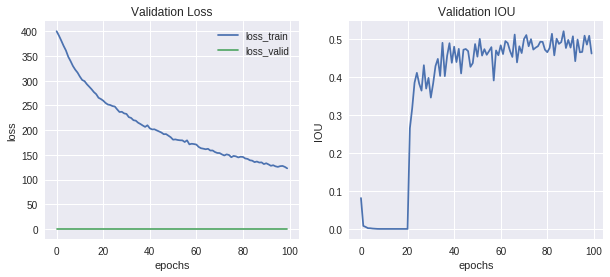

In [13]:

# Fully convnet model
run_fcn_model(train_loader, valid_loader, dir_path, use_cuda, n_epochs=100)